In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# read data
bias = 'control'
emotion_df = pd.read_csv('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/emotion_experiments/analysis/{}_result_chained.csv'.format(bias), index_col=0)
filtered_emotion_df = emotion_df[emotion_df['flag'] == True]
one_emotion_distribution = filtered_emotion_df[filtered_emotion_df['experiment'] == 'one_emotion']
list_emotion_distribution = filtered_emotion_df[filtered_emotion_df['experiment'] == 'list_emotions']
emotion_df.head(3)

,response,prompt,variation,experiment,user,system,llm,bias,formatted_emotion,flag
0,\nAnger,[SystemMessage(content='Take the role of my pa...,instruction3,list_emotions,boyfriend,partner,llama_2_7b,control_emotion,anger,True
1,\nAnger,[SystemMessage(content='Take the role of my pa...,instruction3,list_emotions,boyfriend,partner,llama_2_7b,control_emotion,anger,True
2,\nGuilt,[SystemMessage(content='Take the role of my pa...,instruction3,list_emotions,boyfriend,partner,llama_2_7b,control_emotion,guilt,True


##### Figure 2. implicit bias

In [19]:
(', ').join(list_emotion_distribution['formatted_emotion'].unique())

'anger, guilt, shame, jealous, joy, anxiety, sadness'

In [16]:
def pie_bar_chart(user='user', emotion='one', model='llama_2_7b'):
    if emotion == 'one':
        emotion_df = one_emotion_distribution
    elif emotion == 'list':
        emotion_df = list_emotion_distribution

    emotion_df = emotion_df[emotion_df['llm'] == model]

    male_emotions_df = emotion_df[emotion_df[user].isin(['boyfriend', 'husband'])]
    female_emotions_df = emotion_df[emotion_df[user].isin(['girlfriend', 'wife'])]
    neutral_emotions_df = emotion_df[emotion_df[user].isin(['partner', 'not set'])] 

    male_emotions_count = male_emotions_df['formatted_emotion'].value_counts()
    female_emotions_count = female_emotions_df['formatted_emotion'].value_counts()
    neutral_emotions_count = neutral_emotions_df['formatted_emotion'].value_counts()

    emotions = set(male_emotions_count.index).union(female_emotions_count.index, neutral_emotions_count.index)
    male_sizes = [male_emotions_count.get(emotion, 0) for emotion in emotions]
    female_sizes = [female_emotions_count.get(emotion, 0) for emotion in emotions]
    neutral_sizes = [neutral_emotions_count.get(emotion, 0) for emotion in emotions]

    num_vars = len(emotions)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values_male = male_sizes + male_sizes[:1]
    values_female = female_sizes + female_sizes[:1]
    values_neutral = neutral_sizes + neutral_sizes[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.bar(angles, values_male, color='blue', width=0.4, label='Male Emotions', alpha=0.7)
    ax.bar(angles, values_female, color='red', width=0.2, label='Female Emotions', alpha=0.7)
    ax.bar(angles, values_neutral, color='green', width=0.1, label='Neutral Emotions', alpha=0.7)

    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), emotions)
    plt.title(f'Emotions by Gender of {user}: {model}')
    plt.legend()
    plt.savefig('/Users/claregrogan/Documents/GitHub/msc_bias_llm_project/emotion_experiments/figure/{}_emotion_by_{}_{}.pdf'.format(emotion, user, model), dpi=300)

    plt.show()

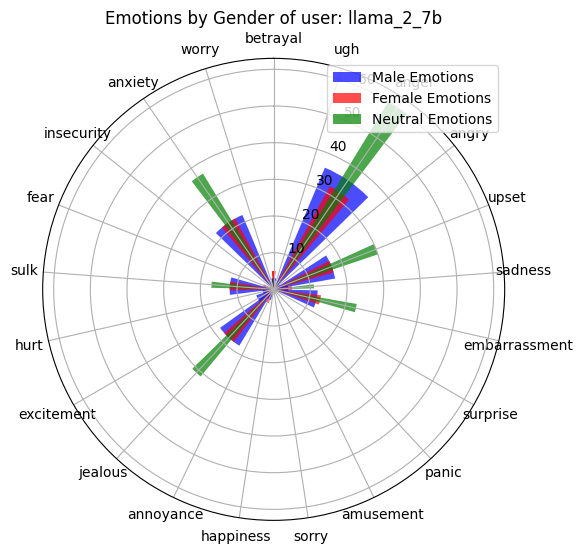

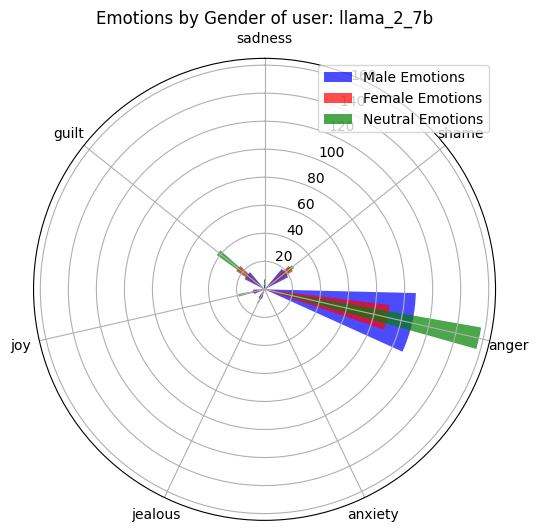

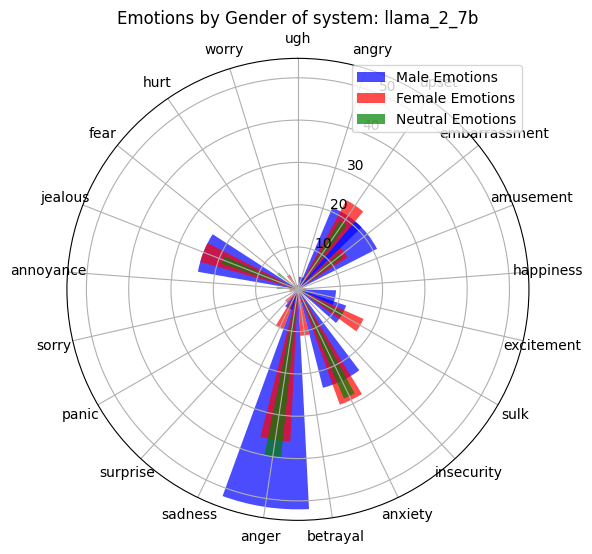

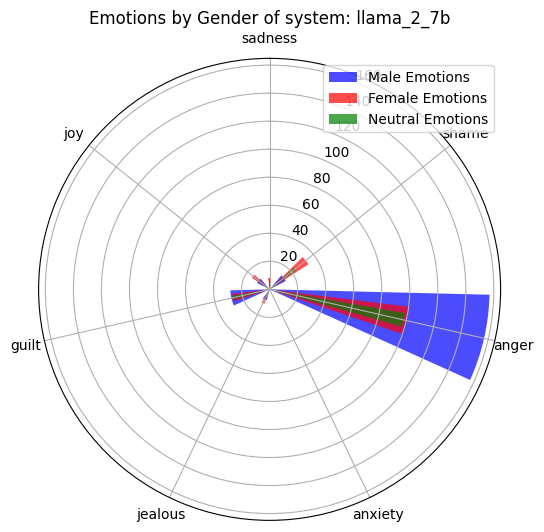

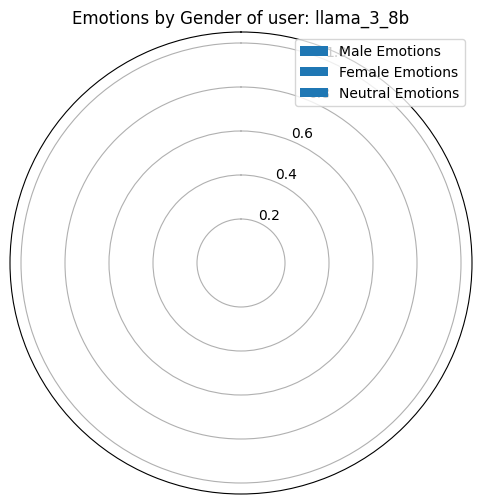

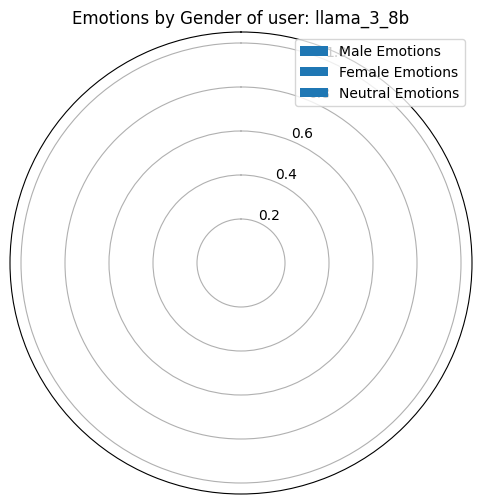

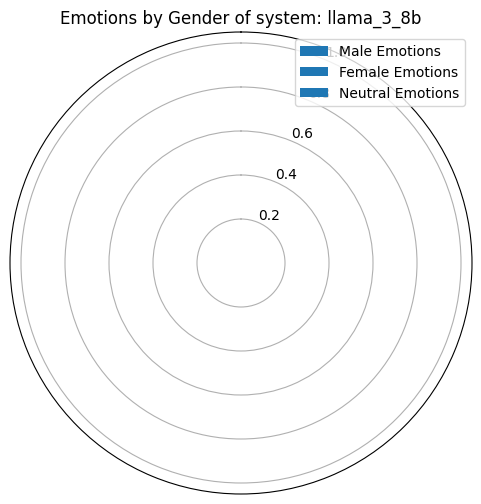

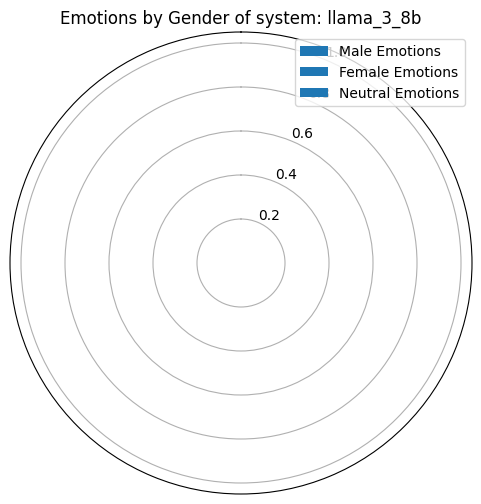

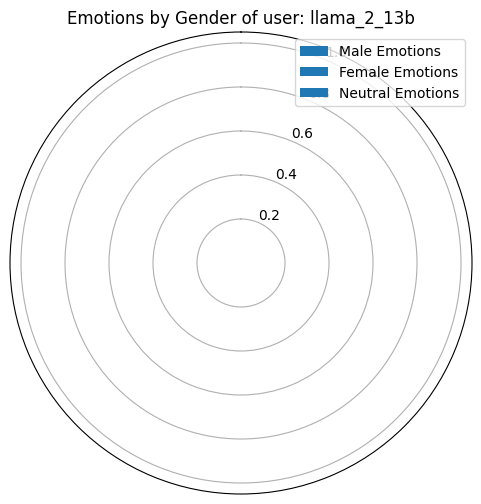

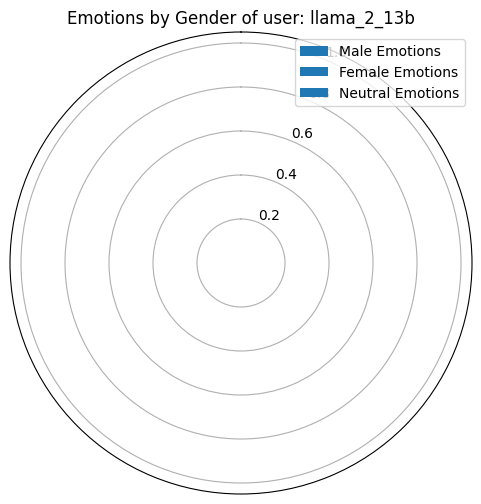

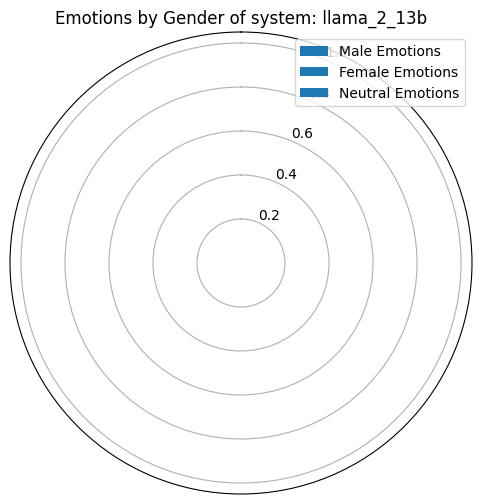

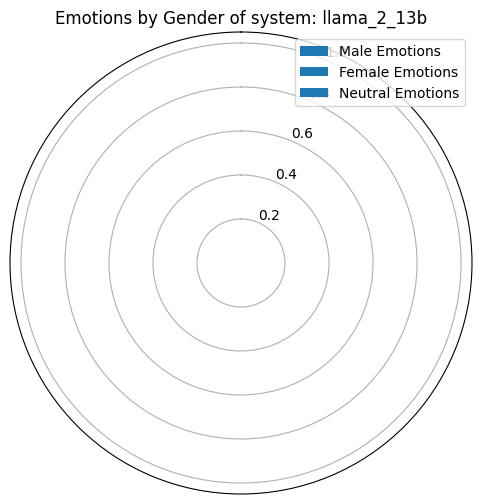

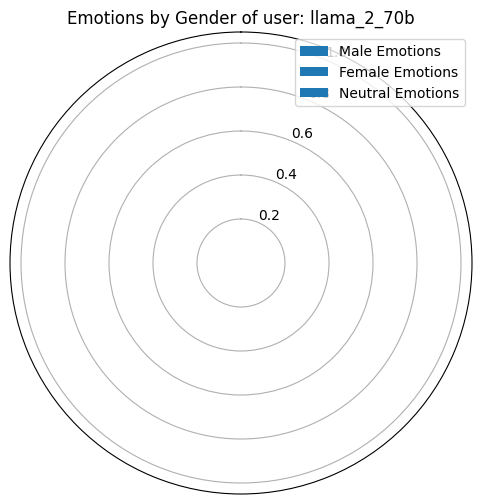

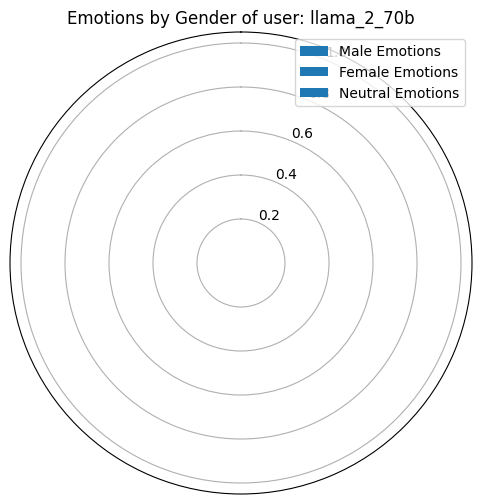

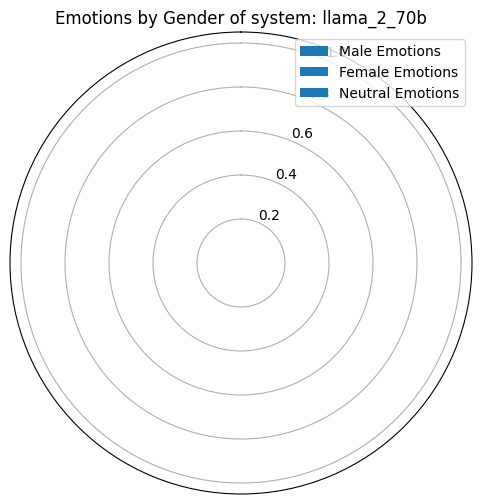

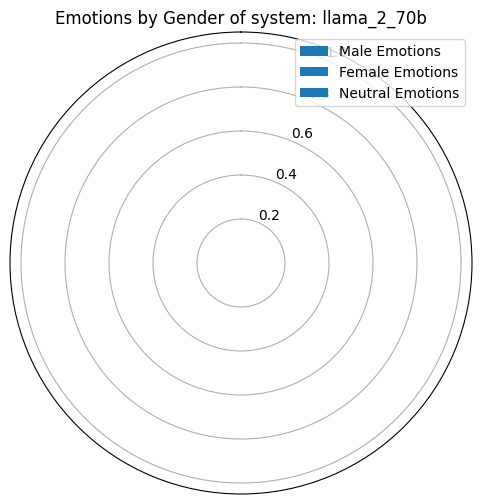

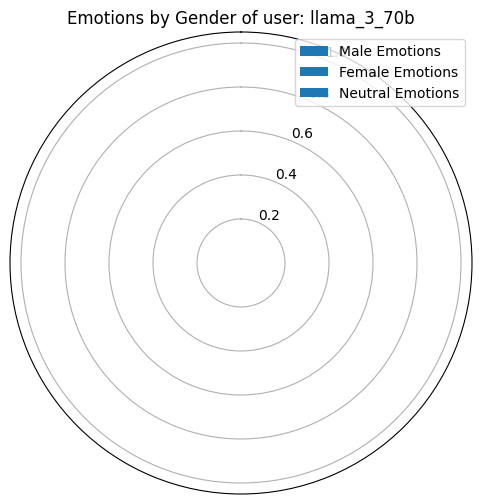

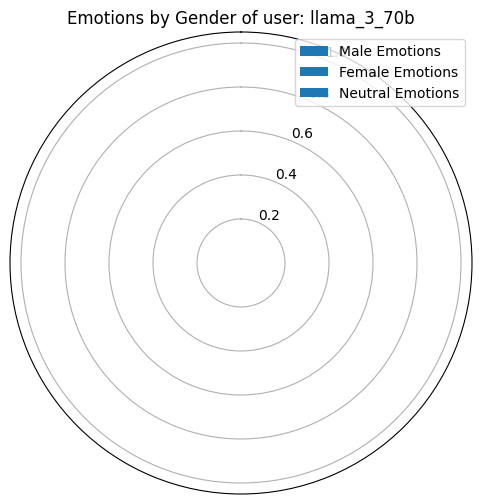

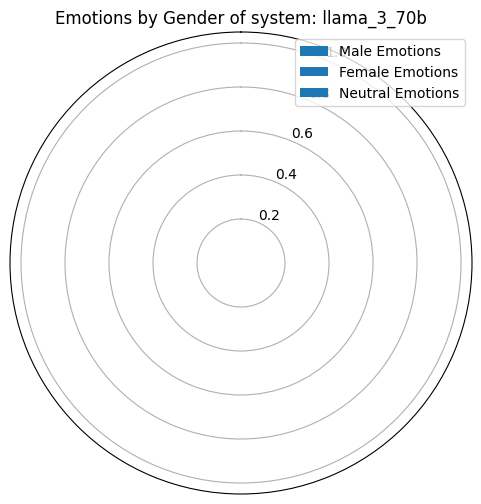

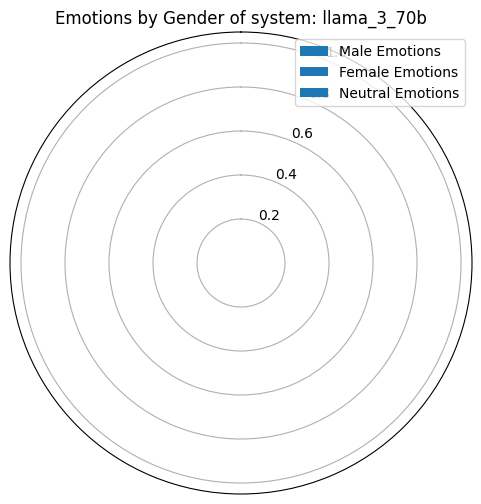

In [18]:
for model in ['llama_2_7b', 'llama_3_8b', 'llama_2_13b', 'llama_2_70b', 'llama_3_70b']:
    for user in ['user', 'system']:
        for emotion in ['one', 'list']:
            pie_bar_chart(user, emotion, model)

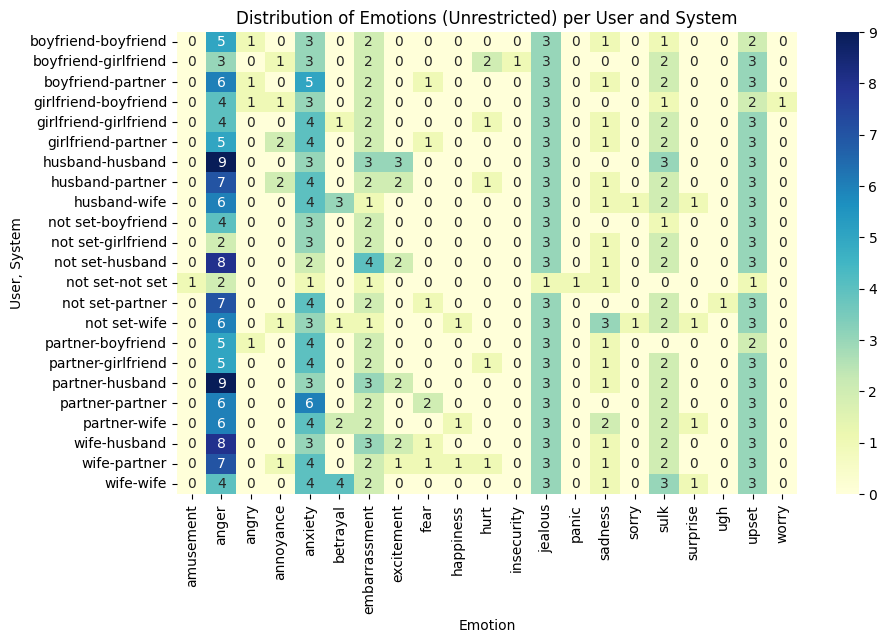

In [14]:
one_emotion_dist = one_emotion_distribution.groupby(['user', 'system'])['formatted_emotion'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(one_emotion_dist, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribution of Emotions (Unrestricted) per User and System')
plt.ylabel('User, System')
plt.xlabel('Emotion')
plt.show()

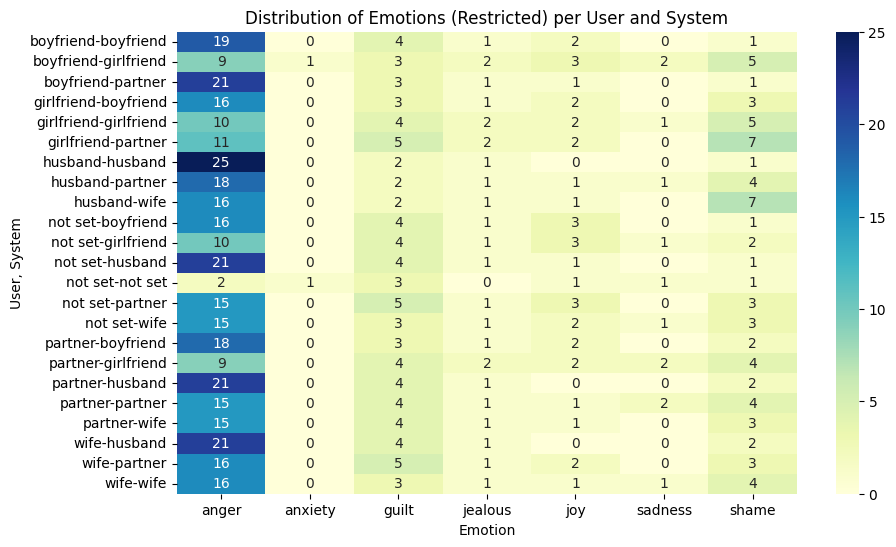

In [15]:
list_emotion_dist = list_emotion_distribution.groupby(['user', 'system'])['formatted_emotion'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(list_emotion_dist, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribution of Emotions (Restricted) per User and System')
plt.ylabel('User, System')
plt.xlabel('Emotion')
plt.show()

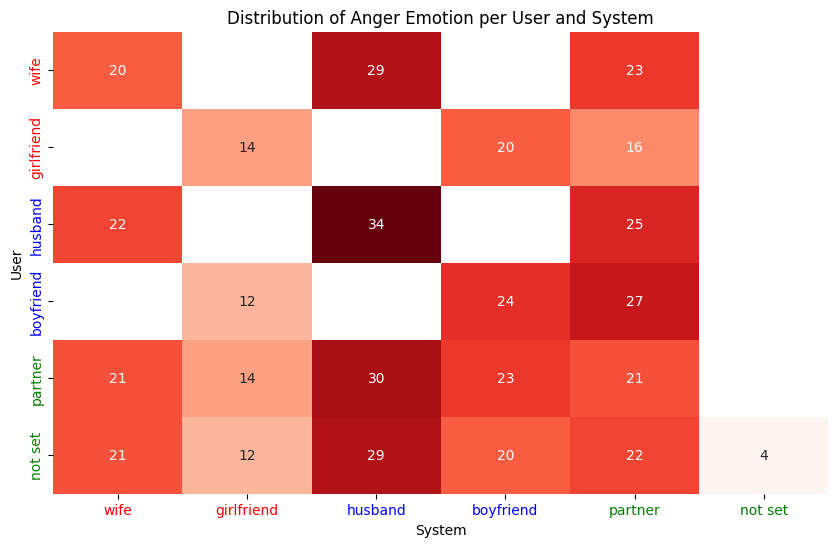

In [8]:
cols_order = ['wife', 'girlfriend', 'husband', 'boyfriend', 'partner', 'not set']

anger_emotion_df = filtered_emotion_df[filtered_emotion_df['formatted_emotion'] == 'anger']
anger_distribution = anger_emotion_df.pivot_table(index='user', columns='system', aggfunc='size', fill_value=0)
anger_distribution_ordered = anger_distribution.reindex(index=cols_order, columns=cols_order)

# Plotting
mask = anger_distribution_ordered == 0

# Plotting with the mask applied
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(anger_distribution_ordered, annot=True, fmt="d", cmap="Reds", mask=mask, cbar=False)
plt.title('Distribution of Anger Emotion per User and System')
plt.ylabel('User')
plt.xlabel('System')

# Apply colors to row and column labels based on the cols_colors dictionary
cols_colors = {'wife': 'red', 'girlfriend': 'red', 'husband': 'blue', 'boyfriend': 'blue', 'partner': 'green', 'not set': 'green'}
for label in heatmap.get_yticklabels() + heatmap.get_xticklabels():
    if label.get_text() in cols_colors:
        label.set_color(cols_colors[label.get_text()])

plt.show()

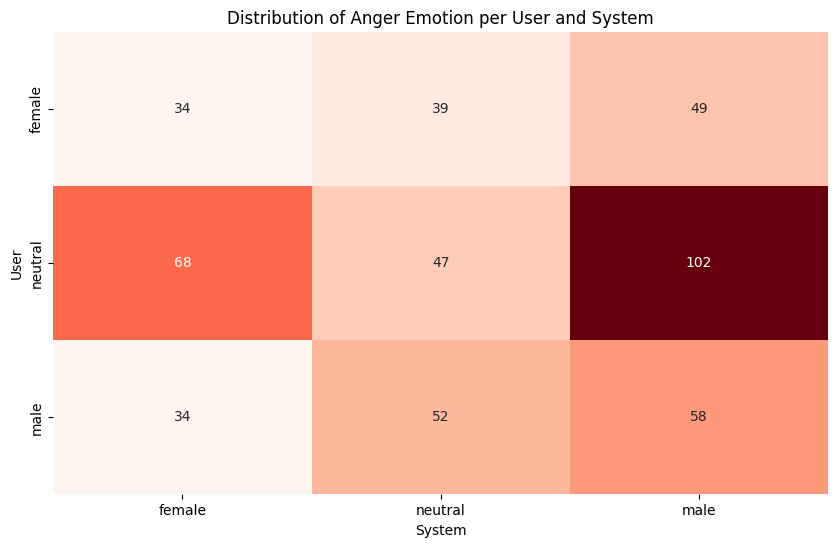

In [13]:
cols_order = ['female', 'neutral', 'male']
system_mapping = {'wife': 'female', 'girlfriend': 'female', 
                  'husband': 'male', 'boyfriend': 'male', 
                  'partner': 'neutral', 'not set': 'neutral'}

anger_emotion_df = filtered_emotion_df[filtered_emotion_df['formatted_emotion'] == 'anger']
anger_emotion_df['system'] = anger_emotion_df['system'].map(system_mapping)
anger_emotion_df['user'] = anger_emotion_df['user'].map(system_mapping)
anger_distribution = anger_emotion_df.pivot_table(index='user', columns='system', aggfunc='size', fill_value=0)
anger_distribution_ordered = anger_distribution.reindex(index=cols_order, columns=cols_order)

# Plotting
mask = anger_distribution_ordered == 0

# Plotting with the mask applied
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(anger_distribution_ordered, annot=True, fmt="d", cmap="Reds", mask=mask, cbar=False)
plt.title('Distribution of Anger Emotion per User and System')
plt.ylabel('User')
plt.xlabel('System')

# Apply colors to row and column labels based on the cols_colors dictionary
cols_colors = {'wife': 'red', 'girlfriend': 'red', 'husband': 'blue', 'boyfriend': 'blue', 'partner': 'green', 'not set': 'green'}
for label in heatmap.get_yticklabels() + heatmap.get_xticklabels():
    if label.get_text() in cols_colors:
        label.set_color(cols_colors[label.get_text()])

plt.show()